In [2]:
import random
from tqdm.notebook import tqdm
import numpy as np
from IPython.display import clear_output
from importlib import reload

import gym
import matplotlib.pyplot as plt
import wandb
import torch

from Learning.utils import ReplayBuffer, plot, plot_test_trajectory, PER_IS_ReplayBuffer
import Learning.agents as ag
import Envs.AYS.AYS_Environment as ays

In [11]:
UPDATE_ONLINE = False
BATCH_SIZE = 256
MAX_EPISODES = 2000
RANDOM_EXPERIENCE = 0
LEARNING_RATE = 3e-4
BUFFER_SIZE = 2**14
REWARD_TYPE = 'PB'
DT = 1
SCHEDULER = (False, 1000, 0.5)
SEED = 0
MAX_STEPS = 600

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

wandbsave = False

config = {
    "learning_rate": LEARNING_RATE,
    "max_episodes": MAX_EPISODES,
    "batch_size": BATCH_SIZE, 
    "online_updating": UPDATE_ONLINE,
    "random_experience": RANDOM_EXPERIENCE,
    "buffer_size": BUFFER_SIZE,
    "reward_type": REWARD_TYPE,
    "dt": DT,
    "scheduler": SCHEDULER,
    "seed": SEED
}
reload(ays)
env = ays.AYS_Environment(discount=0.99,dt=DT, reward_type=REWARD_TYPE)
state_dim = len(env.observation_space)
action_dim = len(env.action_space)

reload(ag)
memory = PER_IS_ReplayBuffer(BUFFER_SIZE, alpha=0.6)
agent = ag.A2C(state_dim, action_dim, alpha=LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.StepLR(agent.optimizer, step_size=SCHEDULER[1], gamma=SCHEDULER[2])

if wandbsave:
    wandb.init(name="AYS_PPO2_policy_cost",config=config,
               entity="climate_policy_optim",  project="AYS_learning")
    wandb.watch(agent.ac_net)

Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


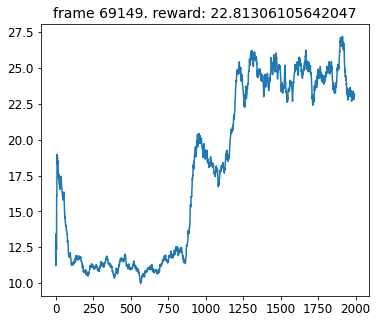

In [12]:
rewards = []
mean_rewards = []
frame_idx = 0
beta = 0.6

for episodes in tqdm(range(MAX_EPISODES)):
    state = env.reset()
    episode_reward = 0
    done = False

    for i in range(MAX_STEPS):
        if episodes>RANDOM_EXPERIENCE:
            action = agent.get_action(state)
        else:
            action = np.random.choice(action_dim)
            
        next_state, reward, done,  = env.step(action)
        
        
        episode_reward += reward
        
        if UPDATE_ONLINE:
            loss = agent.online_update((state, action, reward, next_state, done))
            if wandbsave:
                wandb.log({'loss': loss})
        else:
            memory.push(state, action, reward, next_state, done)
            
        
        state = next_state
        frame_idx += 1 
        if done:
            break
        
    rewards.append(episode_reward)
    mean_rewards.append(np.mean(rewards[-50:]))
    
    if not UPDATE_ONLINE:
        if memory.size > BATCH_SIZE:
            beta = 1-0.4*np.exp(-0.001*episodes) # we converge beta to 1
            sample = memory.sample(BATCH_SIZE, beta)
            loss, tds = agent.update((sample['obs'], sample['action'], sample['reward'], sample['next_obs'], sample['done']))
            new_tds = np.abs(tds.cpu().numpy()) + 1e-6 # compatibility
            memory.update_priorities(sample['indexes'], new_tds)
            if wandbsave:
                wandb.log({'loss': loss})    
                
    if SCHEDULER[0]:
        scheduler.step()
    
    if wandbsave:
        wandb.log({'episode_reward':episode_reward})
        if episodes%200==0:
                plot_test_trajectory(env, agent)
            
    else:
        if episodes%10==0:
            plot(frame_idx, mean_rewards)
            if episodes%30==0:
                plot_test_trajectory(env, agent)

if wandbsave:
    wandb.run.summary["mean_reward"] = np.mean(rewards)
    wandb.run.summary["top_reward"]= max(rewards)
    wandb.finish()

# Using function

In [2]:
from importlib import reload
import learn_class as lc
from Learning import utils as us
import experiments as exp

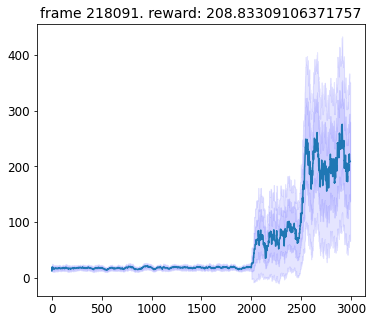

Noise now: 10.0
Success rate:  0.044


episode_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▅▁▁▁▆▁▁▁▁█▇
moving_average,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▃▂▃▃▄▆█▆▆█▇
episode_reward,289.90132
mean_reward,59.55366
moving_average,230.35327
success_rate,0.044
top_reward,753.60005


In [8]:
random = exp.Noisy_Learn(max_frames=2e6, max_episodes=3000, seed=5, wandb_save=True)
random.set_agent("Random")
random.learning_loop_offline(1,1, per_is=False, notebook=True)

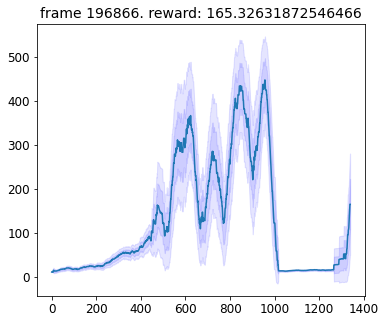

Success rate:  0.19


[9.0825e-05]

In [5]:
ppo = lc.Learn(decay_number=10, max_frames=2e5)
ppo.set_agent("PPO")
ppo.learning_loop_rollout(256, 2048, notebook=True)
ppo.agent.actor_scheduler.get_last_lr()

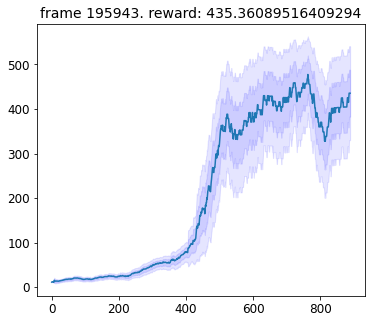

Success rate:  0.364


[7.095703125e-07]

In [6]:
ppo = lc.Learn(decay_number=50, max_frames=2e5)
ppo.set_agent("PPO")
ppo.learning_loop_rollout(256, 2048, notebook=True)
ppo.agent.actor_scheduler.get_last_lr()

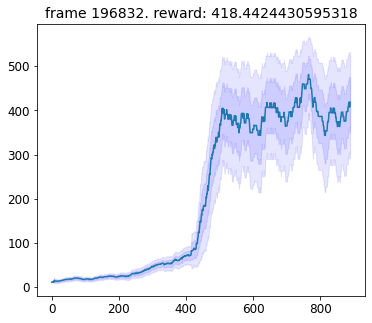

Success rate:  0.359


[6.929397583007812e-10]

In [7]:
ppo = lc.Learn(decay_number=100, max_frames=2e5)
ppo.set_agent("PPO")
ppo.learning_loop_rollout(256, 2048, notebook=True
ppo.agent.actor_scheduler.get_last_lr()

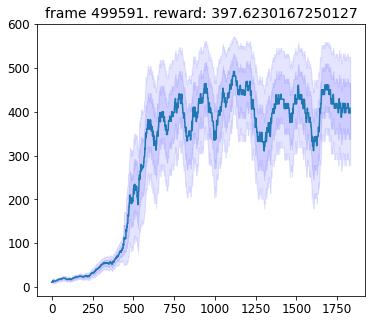

Success rate:  0.527


[6.929397583007812e-10]

In [9]:
ppo = lc.Learn(decay_number=100, max_frames=5e5)
ppo.set_agent("PPO")
ppo.learning_loop_rollout(256, 2048, notebook=True)
ppo.agent.actor_scheduler.get_last_lr()

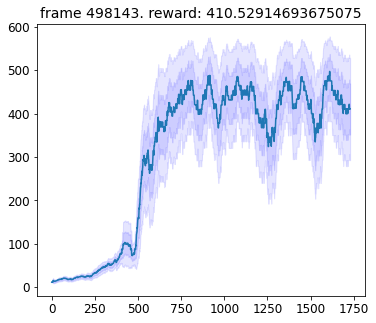

Success rate:  0.533


[6.608388503082096e-16]

In [10]:
ppo = lc.Learn(decay_number=200, max_frames=5e5)
ppo.set_agent("PPO")
ppo.learning_loop_rollout(256, 2048, notebook=True)
ppo.agent.actor_scheduler.get_last_lr()

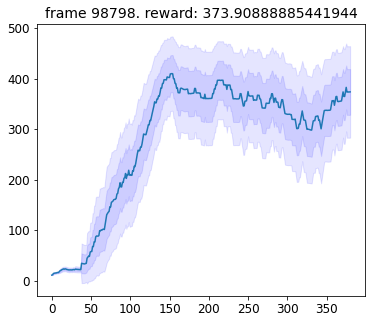

Success rate:  0.62


In [8]:
ppo = lc.Learn(decay_number=0)
ppo.set_agent("DuelDDQN")
ppo.learning_loop_offline(128,32768, per_is=True, notebook=True)

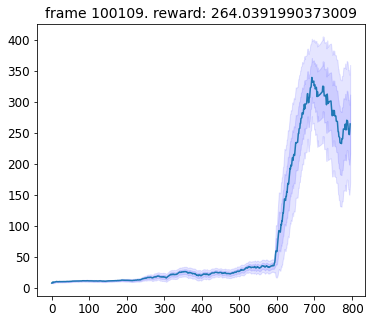

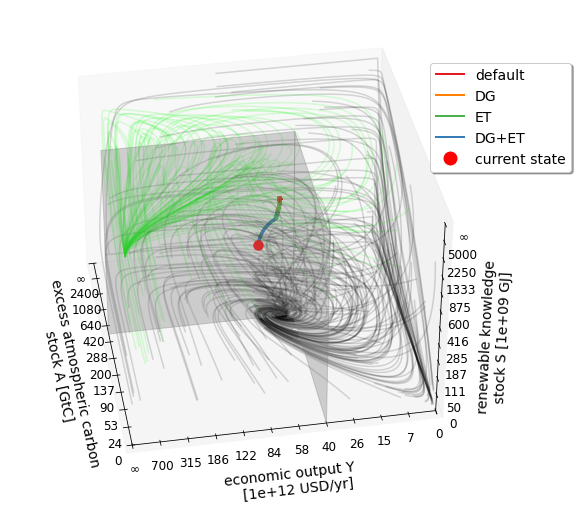

In [2]:
pol_cost = lc.Learn(decay_number=0, reward_type="policy_cost")
pol_cost.set_agent("DQN")
pol_cost.learning_loop_offline(256, 32768, per_is=False, notebook=True, plotting=True) # policy cost of 0.25

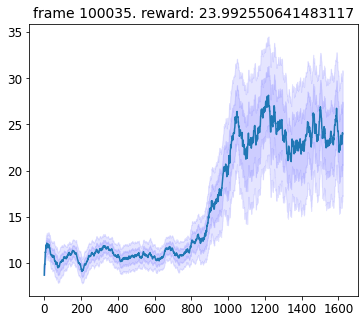

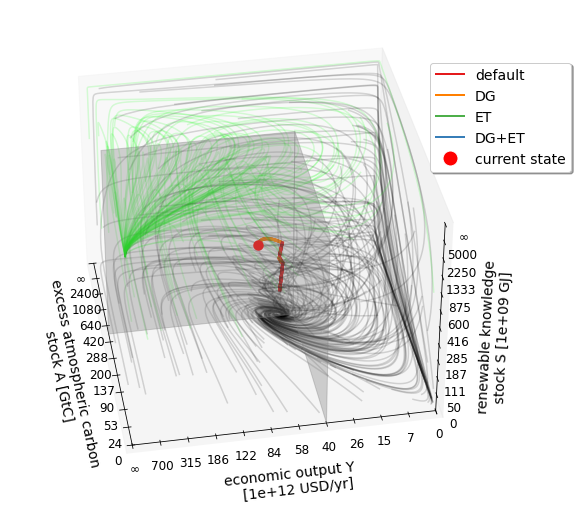

In [3]:
pol_cost = exp.Markov_Learn(decay_number=0, reward_type="policy_cost")
pol_cost.set_agent("DQN")
pol_cost.learning_loop_offline(256, 32768, per_is=False, notebook=True, plotting=True) # policy cost 0.25

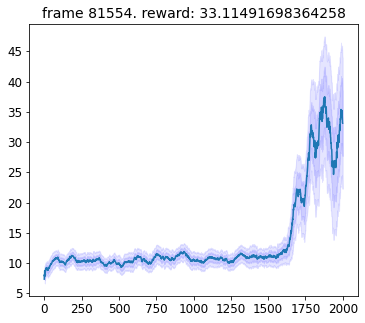

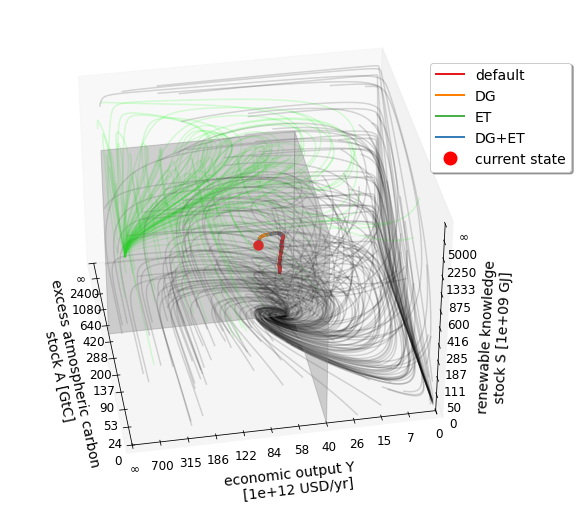

In [3]:
pol_cost = lc.Learn(decay_number=0, reward_type="policy_cost")
pol_cost.set_agent("DQN")
pol_cost.learning_loop_offline(256, 32768, per_is=False, notebook=True, plotting=True) # policy cost of *0.5/*0.25

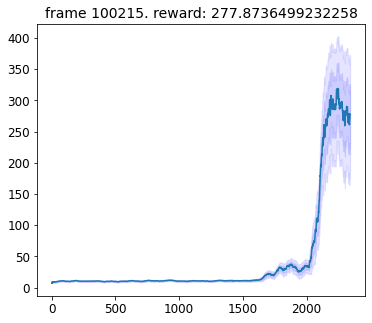

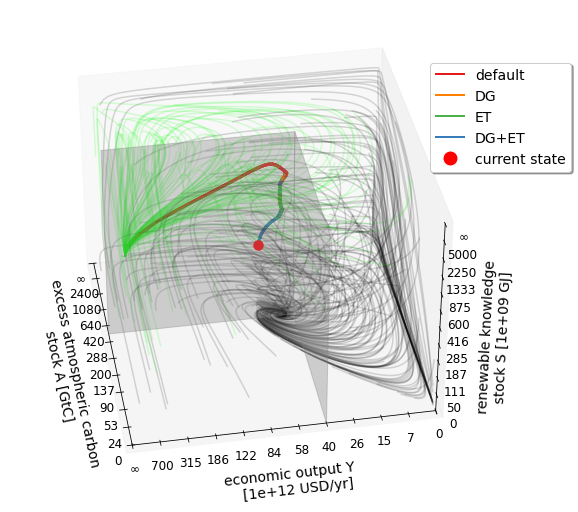

In [4]:
pol_cost.learning_loop_offline(256, 32768, per_is=False, notebook=True, plotting=True) # policy cost of *0.5/*0.25

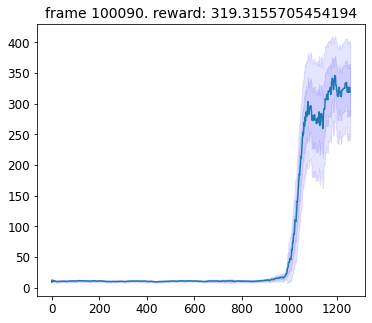

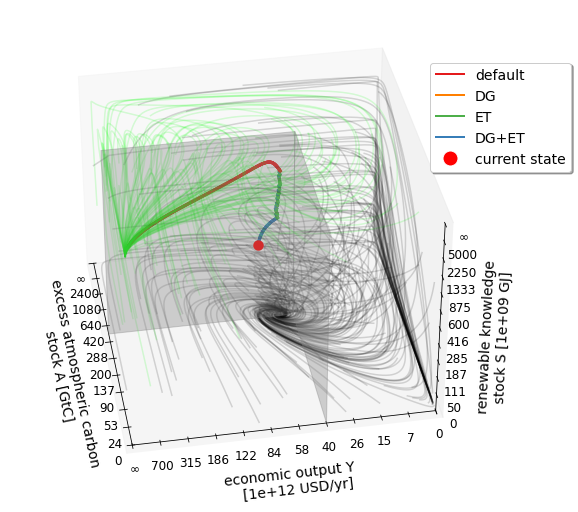

In [5]:
pol_cost = lc.Learn(decay_number=0, reward_type="policy_cost", seed=1, max_episodes=2500)
pol_cost.set_agent("DQN")
pol_cost.learning_loop_offline(256, 32768, per_is=False, notebook=True, plotting=True) # policy cost of *0.5/*0.25

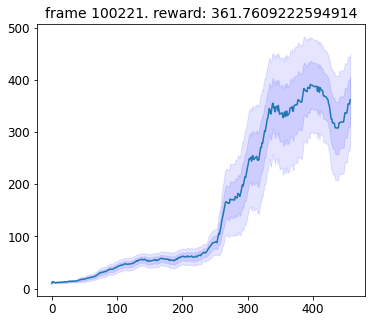

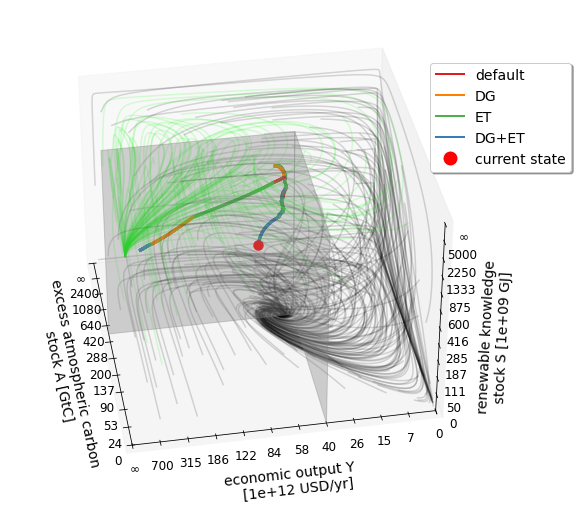

In [2]:
pol_cost = exp.Noisy_Learn(decay_number=0)
pol_cost.set_agent("DQN")
pol_cost.learning_loop_offline(256, 32768, per_is=False, notebook=True, plotting=True)

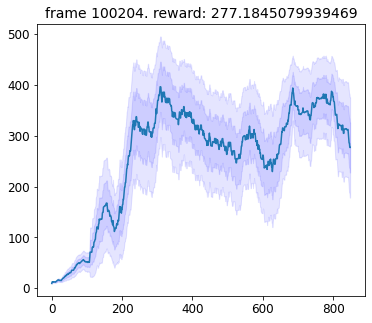

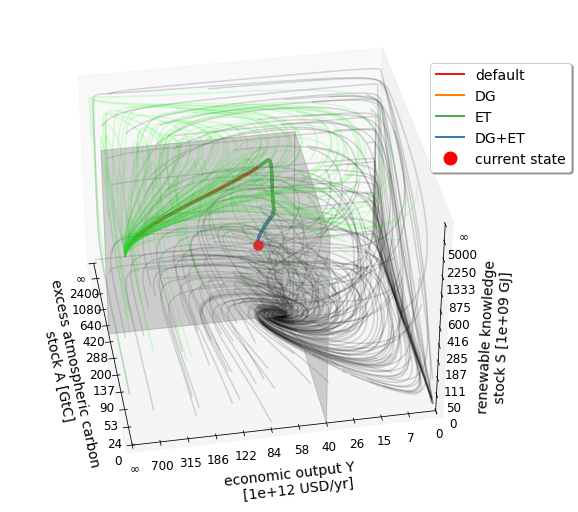

In [6]:
pol_cost.learning_loop_offline(256, 32768, per_is=False, notebook=True, plotting=True)

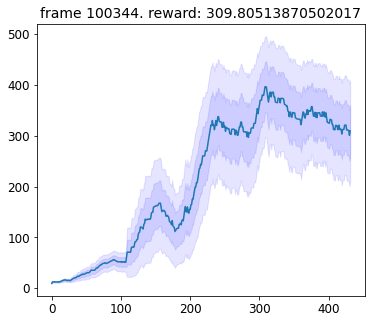

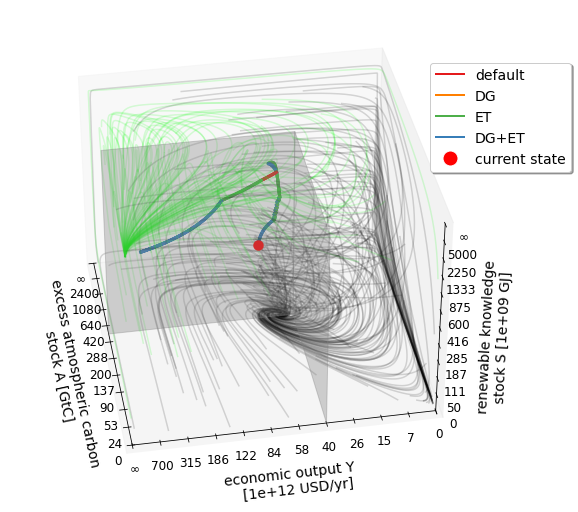

In [5]:
pol_cost = exp.Noisy_Learn(decay_number=0, markov=True)
pol_cost.set_agent("DQN")
pol_cost.learning_loop_offline(256, 32768, per_is=False, notebook=True, plotting=True)

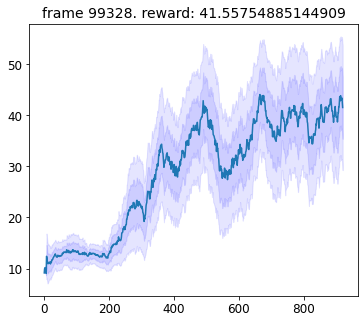

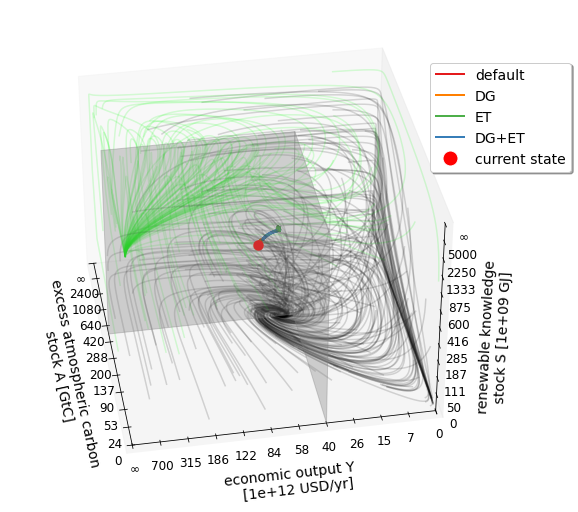

In [2]:
pol_cost = lc.Learn(reward_type="policy_cost")
pol_cost.set_agent("PPO")
pol_cost.learning_loop_rollout(32, 1024, notebook=True, plotting=True)

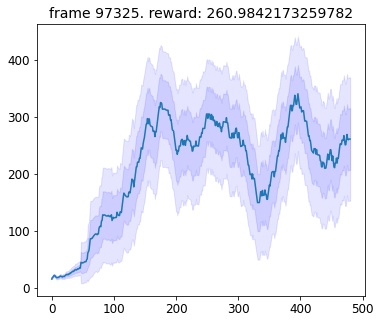

0.44285714285714284


In [2]:
markov = exp.Markov_Learning()
markov.set_agent("DuelDDQN")
markov.learning_loop_offline(128, 2**13, per_is=True, notebook=True)

IndexError: list index out of range

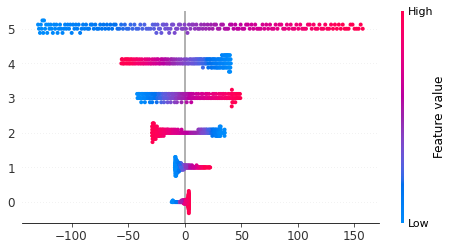

In [5]:
markov.feature_plots(200, v=True)

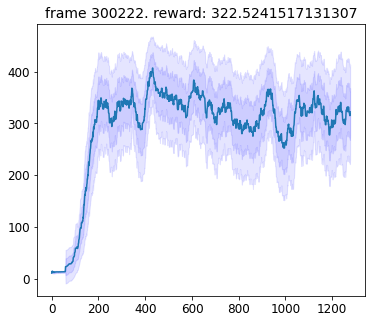

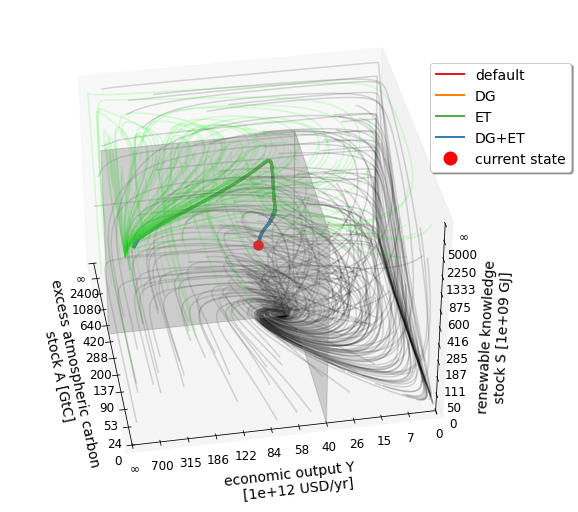

In [2]:
reload(lc)
experiment = lc.Learning(max_frames=3e5, verbose=False, max_epochs=75, seed=0, reward_type='PB')
experiment.set_agent("DuelDDQN")
experiment.learning_loop_offline(64, 10000, per_is=True, plotting=True, notebook=True)

# hparam sweep


In [2]:
from learn_class import Learn
import wandb
wandb.login()

wandb: Currently logged in as: theowolf (climate_policy_optim). Use `wandb login --relogin` to force relogin


True

In [6]:
def trainppo():
    with wandb.init():
        config = wandb.config
        experiment = Learn(wandb_save=True, max_frames=1e5, max_episodes=5000, decay_number=config.decay_number)
        experiment.set_agent("PPO", lr_actor=config.lr_actor, lr_critic=config.lr_critic, epsilon=config.epsilon, lamda=config.lamda, clip=config.clip)
        experiment.learning_loop_rollout(buffer_size=config.buffer_size, 
                                         batch_size=config.batch_size)
def traindqn():
    with wandb.init():
        config = wandb.config
        experiment = Learn(wandb_save=True, max_frames=1e5, max_episodes=5000, decay_number=config.decay_number)
        experiment.set_agent("DQN", lr=config.lr, rho=config.rho, tau=config.tau)
        experiment.learning_loop_offline(buffer_size=config.buffer_size, 
                                         batch_size=config.batch_size,
                                         per_is=False)
def trainA2C():
    with wandb.init():
        config = wandb.config
        experiment = Learn(wandb_save=True, max_frames=5e5, max_epochs=1, max_episodes=10000, decay_number=config.decay_number)
        experiment.set_agent("A2C", epsilon=config.epsilon, lr_actor=config.lr_actor, lr_critic=config.lr_critic, lamda=0.)
        experiment.learning_loop_rollout(buffer_size=config.batch_size, 
                                         batch_size=config.batch_size)



In [7]:
wandb.agent("mweqyc1f" , function=trainA2C, project="AYS_learning")

wandb: Agent Starting Run: ngjy5h2r with config:
wandb: 	batch_size: 32
wandb: 	decay_number: 5
wandb: 	epsilon: 0.01059437419155005
wandb: 	lr_actor: 0.001840519026443272
wandb: 	lr_critic: 0.0006078785564840312


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,▇▅▇▇▆▆▅▄▆▂▄█▂▂▃█▃▃▅▅▁▄▅▃▄▆▃▂▄▄▃▅▇▃▄▃▄▄▆▃
loss,▃▃▁▃▃▃▁▃▃▇▇▄▃▆▄▄▄█▄▄▇▄▃▆▄▆▄▃▄▅▄▇▄▄▄▄▄▄▄▄
moving_average,▂█▂▄▃▄▄▂▂▃▃▂▃▄▅▄▂▅▃▄▄▃▁▂▁▂▃▂▃▃▂▃▅▃▄▃▂▃▄▃
pol_loss,▇▁█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▃▁▃▃▃▁▃▃▇▇▄▃▆▄▄▄█▄▄▇▄▃▆▄▆▄▃▄▅▄▇▄▄▄▄▄▄▄▄
episode_reward,11.79927
loss,5.82901
mean_reward,12.89096
moving_average,13.38725
pol_loss,-0.0
success_rate,0.0


wandb: Agent Starting Run: zw855y5y with config:
wandb: 	batch_size: 128
wandb: 	decay_number: 1
wandb: 	epsilon: 0.0009714592363758472
wandb: 	lr_actor: 8.118129669549771e-05
wandb: 	lr_critic: 0.00011265772745847213


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,▂▆▁▅█▃▅▆▂▃▇▄▄█▅▃▂▃▃▃▃▇▇▄▁▃▅▁▁▃▅▃▃▇▄▇▄▂▃▅
loss,▁▁▁▁▃▄▆▅▆▆▆▄▅▄▅▆▆▇▆▄▅▆▅▅█▄▅▆▆▅▅▅▆▅▅▅▅▅█▆
moving_average,█▆▆▆▆▂▃▃▂▂▅▅▇▆█▃▁▁▃▃▃▅▅▃▄▂▃▃▁▄▂▂▂▂▃▁▁▁▂▂
pol_loss,██▇▆▅▅▄▅▄▄▃▅▄▅▅▅▄▃▄▄▅▄▄▄▁▃▆▅▄▄▅▅▄▂▃▄▂▃▄▅
val_loss,▁▁▁▂▃▄▆▅▆▆▆▄▅▄▅▆▆▇▆▅▅▆▅▅█▅▅▆▆▅▅▅▆▅▅▅▅▅█▆
episode_reward,11.6616
loss,4.44168
mean_reward,14.21955
moving_average,13.25864
pol_loss,-0.13027
success_rate,0.0


wandb: Agent Starting Run: 5fmga2ai with config:
wandb: 	batch_size: 2048
wandb: 	decay_number: 6
wandb: 	epsilon: 0.002784331889529426
wandb: 	lr_actor: 0.002849558450401787
wandb: 	lr_critic: 0.005364446574431679


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,▄▆▃▄▅▃█▄▄▅▂▁▃▂▃▂▃▃▃▁▄▃▁▃▂▄▅▃▁▂▃▃▄▃▂▃▂▃▄▄
loss,▁▁▂▆█▅▃▃▅▆▅▄▄▄▄▅▅▄▄▄▅▄▅▅▄▄▄▅▅▅▅▆▅▇▆█▆▇▇▇
moving_average,▄▆▄▅▇█▇▄▃▃▃▂▂▃▂▂▃▃▃▁▄▂▃▂▂▂▂▂▁▂▃▃▃▂▂▂▃▃▂▂
pol_loss,█▇▄▂▁▂▃▃▂▃▂▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val_loss,▁▁▃▆█▅▃▄▅▆▆▄▄▄▄▅▅▅▄▅▅▄▅▅▅▅▅▅▅▅▅▆▅▇▆█▆▇▇▇
episode_reward,12.92899
loss,7.19182
mean_reward,13.35573
moving_average,13.039
pol_loss,-0.0001
success_rate,0.0


wandb: Agent Starting Run: it6fts84 with config:
wandb: 	batch_size: 256
wandb: 	decay_number: 0
wandb: 	epsilon: 0.0004085187484560882
wandb: 	lr_actor: 0.00016581624986916776
wandb: 	lr_critic: 9.330921342353627e-05


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.004


episode_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
loss,▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂█▃▃▂▂▂▂▂
moving_average,▃▂▃▃▂▂▂▂▂▂▂▂▃▂▂▂█▂▇▁▂▁▂█▂▁▂▂▂▂▃▅▅▂▁▁▁▁▁▁
pol_loss,▇▇▇▇▇▇▆▆▅▅▅▄▅▃▃▃▄▂▄▃▃▁▃▄▂▇▃▄▆▃▅▂█▃▃▂▃▄▄▄
val_loss,▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▃▂▂▂▂▂▁▂▂▁▂▂▃█▃▃▂▂▂▂▂
episode_reward,17.40127
loss,5.85007
mean_reward,16.85038
moving_average,14.14438
pol_loss,0.1377
success_rate,0.0044


wandb: Agent Starting Run: 9aduvlid with config:
wandb: 	batch_size: 32
wandb: 	decay_number: 1
wandb: 	epsilon: 0.004065369206321492
wandb: 	lr_actor: 0.0001432388769018823
wandb: 	lr_critic: 0.006829778291314674


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.06


episode_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁█
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▃█▁▁▁▂▅▁█▃▁▁▁▁▁▁▅▁▁
moving_average,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▄▅▅▆█
pol_loss,▇▆▅▆▇▆█▆█▇▆▄▆▇▇▇▅▇██▇▅▃▇██▇▃▇▁▇█▇██▇▇▅▇▇
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▃█▁▁▁▂▅▁█▃▁▁▁▁▁▁▅▁▁
episode_reward,14.53194
loss,0.10381
mean_reward,49.08843
moving_average,333.01471
pol_loss,1e-05
success_rate,0.05965


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8mke83fq with config:
wandb: 	batch_size: 32
wandb: 	decay_number: 0
wandb: 	epsilon: 0.010772958947459142
wandb: 	lr_actor: 0.0001895217371612915
wandb: 	lr_critic: 0.005301233606374597


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,▂▁▁▁▁▂▂▂▂▁▅▂▂▁▁▃▂▁▂▁▂▂▇▁▂█▆▂▂█▄▁▆▂▆▂▂▇▁█
loss,▂▂▂▁▂▄▂▁▁▂▃▁▃▁▃▃▄▁▆▁▂▄▃▁▁▅▁▁▁▁▁▁█▁▄▁▁▁▁▁
moving_average,▂▂▁▁▁▁▂▂▁▁▂▂▂▂▂▃▃▂▂▃▃▃▅▄▅▅▅▅▅▆▇▅▆▆▇▆▇█▆▇
pol_loss,▆▅▆█▅▄▆█▇▆▂█▃▆▆▆▅▇▄▆▆▆▆▇▆▆▇▇▆▆▇▇▁▆▄▆▇▆▆▇
val_loss,▂▂▂▁▂▄▂▁▁▂▃▁▃▁▃▃▄▁▆▁▂▄▃▁▁▅▁▁▁▁▁▁█▁▄▁▁▁▁▁
episode_reward,68.58019
loss,-0.06104
mean_reward,27.93075
moving_average,46.90396
pol_loss,-0.0771
success_rate,0.0


wandb: Agent Starting Run: xo009hkv with config:
wandb: 	batch_size: 64
wandb: 	decay_number: 2
wandb: 	epsilon: 0.0027844897222090255
wandb: 	lr_actor: 0.00035538877114510523
wandb: 	lr_critic: 0.002767599081140503


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.021


episode_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▂▁▁▁██
loss,▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂▂▁▁▁█▁▁▁▁▁
moving_average,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▆█
pol_loss,▆▆▆▆▅▃▆▅▄▅▃▇▃▄▅▆▅▄▆▆▆▇▆▇▃▆▇▆▆▃▅▆█▇▁▆▆▆▆▆
val_loss,▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂▂▁▁▁█▁▁▁▁▁
episode_reward,525.66578
loss,0.1739
mean_reward,34.27982
moving_average,308.02165
pol_loss,0.11167
success_rate,0.02132


wandb: Agent Starting Run: jxm74905 with config:
wandb: 	batch_size: 32
wandb: 	decay_number: 3
wandb: 	epsilon: 0.003635475241637538
wandb: 	lr_actor: 0.0003862478872661248
wandb: 	lr_critic: 0.004699798282594992


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.073


episode_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁██▂
loss,▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▂▁▆▁▁▁▁▁█▁▇▁▃▁▁▁▁▁▁▁▁▁▁▁▁
moving_average,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▂▁▁▂▁▂▃▄▄▆█▇█
pol_loss,▆▇▆▅▇▆▆▆▇▆▆▆█▆▆▅▇▇▇▇▆▆▆▁▆▄▇▆▆▆▆▇▆▇▆▆▇▆▆▇
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▂▁▆▁▁▁▁▁█▁▇▁▃▁▁▁▁▁▁▁▁▁▁▁▁
episode_reward,119.01559
loss,0.03407
mean_reward,55.30579
moving_average,306.26771
pol_loss,8e-05
success_rate,0.07282


wandb: Agent Starting Run: ojtewpu6 with config:
wandb: 	batch_size: 32
wandb: 	decay_number: 4
wandb: 	epsilon: 0.0013749308788440877
wandb: 	lr_actor: 0.00017216577824869666
wandb: 	lr_critic: 0.0037612483081425506


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.09


episode_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▂▁▁▂█▁█▁█▁
loss,▂▁▁▁▁▁▁▂▁▂▁▁▂▁▁▃█▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁
moving_average,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▅▆▆█▇██
pol_loss,▄▅▆▄█▄█▄▇▄▅▇▅██▄▃▄▅▅▁▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▅▅▆▅
val_loss,▂▁▁▁▁▁▁▂▁▂▁▁▂▁▁▃█▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁
episode_reward,538.8226
loss,-0.11334
mean_reward,66.53784
moving_average,278.62829
pol_loss,-0.15424
success_rate,0.0903


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y6ifjfjt with config:
wandb: 	batch_size: 32
wandb: 	decay_number: 5
wandb: 	epsilon: 0.002092732959365449
wandb: 	lr_actor: 0.00030813728058683414
wandb: 	lr_critic: 0.009143601747732351


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,▁▂▂▂▁▁▁▁▁▂▂▂▂▂▁▁▂▁▁▃▅▂▁▂▁▅▃█▂▂▁▆▂▁▁▁▁▁▂▂
loss,▂▂▅▃▃▂▂▁▃▂▁▄▁▃▁▆▁▃▃▁▁▁▁▄█▅▁▇▅▁▁▁▁▁▄▁▂▂▃▂
moving_average,▂▁▁▂▂▁▁▂▁▃▂▂▂▂▂▁▁▂▁▃▂▃▃▄▃▄▄▅▆▃▆▆▇█▁▁▁▁▁▁
pol_loss,▆▆▃▆▆▄▆▇▅▆▆▄▇▅█▁▆▆▅▆▆█▆▆▂▂▆▂▆▆▆▇▇▇▆▇▇▆▆▇
val_loss,▂▂▆▃▃▂▂▁▃▂▁▄▁▃▁▆▁▃▃▁▁▁▁▃█▅▁▇▄▁▁▁▁▁▄▁▂▂▃▂
episode_reward,11.36995
loss,5.42725
mean_reward,18.0829
moving_average,12.51542
pol_loss,-0.00307
success_rate,0.0


wandb: Agent Starting Run: ngcl79ci with config:
wandb: 	batch_size: 32
wandb: 	decay_number: 0
wandb: 	epsilon: 0.13206921474292546
wandb: 	lr_actor: 8.693586030247765e-05
wandb: 	lr_critic: 0.00094775732678967


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,▁▁▂▃▂▅▂▁▂▂▁▁▄▁▂▂▃▂▁▁▂▁▂▁▁▃▁▂▂▂▇▂▂▂▅▂██▂▄
loss,▄▂▃▃▆▃▁▆▂▅▆▅▅▃▄▅▁▁▁▅▄▁▁▇▁▁▁▅▁▁▆▅▁▁▁▁▅▁█▁
moving_average,▁▂▁▁▁▂▁▁▂▂▂▂▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▆▅▅▅▇▄█▇▇▇▇▇
pol_loss,▆▆▆▅▂▆█▃▇▄▂▄▂▄▄▃▇▇▆▄▄▆█▁▇▆▆▅▆▆▅▅▇▇▆▆▅▇▁▆
val_loss,▃▂▃▃▆▃▁▆▂▅▆▅▅▃▄▅▁▁▁▅▄▁▁▇▁▁▁▄▁▁▆▅▁▁▁▁▅▁█▁
episode_reward,14.91644
loss,15.57172
mean_reward,22.71961
moving_average,33.08516
pol_loss,-1.14702
success_rate,0.0


wandb: Agent Starting Run: g7rkag13 with config:
wandb: 	batch_size: 2048
wandb: 	decay_number: 10
wandb: 	epsilon: 0.001362070543490598
wandb: 	lr_actor: 2.0873543959059736e-05
wandb: 	lr_critic: 2.0418028749427728e-05


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,▂▂▁▃▃▂▂▁▂▁▂▄▂▃▃▃▃▃▂▃▂▂▃▂▂▂▃▇▇▄█▃▁▂▂▂▄▆▂▂
loss,▆▇▅█▄▇▄▆▅▇▄▄▆▆▇▆▄▂▅▄▆▃▄▅▃▄▃▂▁▂▃▅▄▃▃▄▂▄▃▂
moving_average,▅▆▂▃▇▄▄▅▆▁▂▄▃▂▂▆█▄▅▄▄▄▃▂▂▅▅▄▃▃▅▂▂▄▄▄▆▃▄▄
pol_loss,▇▇▆█▅▇▅▆▆▇▄▄▆▆▆▆▅▃▅▄▅▃▄▄▃▃▂▂▁▂▂▃▃▂▂▂▁▂▂▁
val_loss,▅▅▃█▂▇▃▅▄▇▃▃▅▆█▇▄▁▆▄▇▂▅▇▃▄▃▃▁▂▅▇▇▄▆▇▅█▆▅
episode_reward,16.2358
loss,0.90798
mean_reward,17.1488
moving_average,14.44191
pol_loss,0.64626
success_rate,0.0


wandb: Agent Starting Run: uvssswnz with config:
wandb: 	batch_size: 256
wandb: 	decay_number: 1
wandb: 	epsilon: 0.04144282128968344
wandb: 	lr_actor: 0.0005534868476082317
wandb: 	lr_critic: 0.009806854026188002


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.065


episode_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▂▁▁▁▁▁
loss,▁▁▂▂▂▂▂▂▂▂▂▂▂▁█▂▁▂▂▂▄▇▄▄▄▆▁▁▁▁▃▁▃▁▂▂▁▄▁▁
moving_average,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▃▁▁▁▁▃▄▃▂▃▅▆█▇
pol_loss,▅▅▂▄▄▃▂▂▂▁▂▄▂█▁▅▇▅▅▇▅▄▄▆▆▂▇▆▅▅▅▆▆▅▇▅▆▅▆▆
val_loss,▁▁▂▂▂▂▂▂▂▂▂▂▂▁█▂▁▂▂▂▄▆▄▄▄▆▁▁▁▁▃▁▃▁▂▂▁▄▁▁
episode_reward,539.09243
loss,9.51762
mean_reward,50.71141
moving_average,268.71574
pol_loss,0.17192
success_rate,0.06464


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0olmnkv9 with config:
wandb: 	batch_size: 1024
wandb: 	decay_number: 10
wandb: 	epsilon: 0.05731467769015833
wandb: 	lr_actor: 0.0013535668724371057
wandb: 	lr_critic: 2.505292357303738e-05


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,▂▄▂▂▃▁▂▂█▇▂▂▂▅▃▂▂▁▄▂▁▂▅▇▃▂▂▂▇▃▃▃▂█▄▄▂▃▂▃
loss,▇█▆▇██▇▆▅▄▂▃▄▁▅▅▃▄▄▂▅▆▂▂▂▃▁▅▂▆▂▆▂▄▂▃▅▁▂▅
moving_average,▂▃▅▅▄▂▃▂▆▅▄▂▃▅▆▅▃▃▅▄▄▃▅▃▄▃▂▂▄█▃▄▁▄▆▅▂▅▂▂
pol_loss,▇█▇███▇▇▇▆▅▅▆▄▆▆▅▅▅▄▅▅▄▄▄▄▃▄▃▄▃▄▂▃▂▂▂▁▂▁
val_loss,▂▂▂▂▃▃▃▂▂▂▁▂▂▁▃▃▂▃▂▂▃▄▂▂▂▃▃▅▃▅▃▆▄▅▄▅▇▄▅█
episode_reward,9.41559
loss,0.8266
mean_reward,17.58126
moving_average,15.73335
pol_loss,0.49545
success_rate,0.0


wandb: Agent Starting Run: 97c6ojvr with config:
wandb: 	batch_size: 1024
wandb: 	decay_number: 3
wandb: 	epsilon: 0.005912326947992488
wandb: 	lr_actor: 0.0035635440408756185
wandb: 	lr_critic: 0.0005160890899890342


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,▅▂█▅▄▅▆▂▃▅▅▁▃▃▃▅▄▅▆▃▇▃▃▄▅▆▅▃▄▆▃▃▄▆▂▆▇▇▇▃
loss,▁▁▁▁▁▁▂▂▃▄▅▆▇▇████▇▇▆▇▇▇▇▇█▇▇▇▆▇▇▇▇▇▇▇▇▇
moving_average,▅▃█▄▁▃▆▆▃▄▆▄▄▄▅▄▄▅▄▃▄▁▂▄▄▂▄▁▂▂▂▄▂▄▄▄▃▅▄▂
pol_loss,█▇▇▆▅▅▅▄▄▃▃▃▃▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val_loss,▁▁▁▁▁▂▂▃▃▅▅▆▇▇████▇▇▆▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇
episode_reward,15.36103
loss,4.96149
mean_reward,13.10917
moving_average,12.5117
pol_loss,0.0
success_rate,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qlhh6fsr with config:
wandb: 	batch_size: 256
wandb: 	decay_number: 7
wandb: 	epsilon: 0.008616329400981062
wandb: 	lr_actor: 0.00014099799958727872
wandb: 	lr_critic: 0.0015151901270822794


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,▅▂▄▃█▄▃▄▂▂▃▃▂▄▃▂▄▂▂▄▃▄▃▅▁▂▃▄▄▂▃▂▃▄▄▄▄▆▂▁
loss,▁▆▆▅▃▃▄▆▆▅▆▄▅▅▆█▆▆▆▇█▆▅▆▆▆▆▇▆▅▆▆▅▅▅▆▆▄▅▅
moving_average,█▆▅█▇▄▇▅▄▂▄▃▃▃▂▂▃▃▁▃▃▂▂▁▃▂▂▃▃▂▃▂▃▄▄▂▅▆▅▅
pol_loss,█▅▄▄▅▇▆▆▅▄▂▄▃▅▆▃▁▄▄▅▄▂▄▃▂▂▃▂▁▄▂▄▃▄▃▂▃▄▃▄
val_loss,▁▆▆▅▃▃▄▆▆▅▇▄▅▅▅█▆▆▆▇█▇▅▆▇▇▆▇▇▅▆▆▆▅▅▇▆▄▅▅
episode_reward,21.3044
loss,6.21464
mean_reward,13.85804
moving_average,15.49282
pol_loss,-0.36418
success_rate,0.0


wandb: Agent Starting Run: fpo8zcop with config:
wandb: 	batch_size: 1024
wandb: 	decay_number: 4
wandb: 	epsilon: 0.00026398518834971414
wandb: 	lr_actor: 3.966784379676021e-05
wandb: 	lr_critic: 0.0002056918950024252


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,▃▁▁▃▇▃▇▂▃▂▄█▂▁▁▂▃▂▃▃▃▂▃▅▂▁▂▃▂▃▂▅▁▂▂▂▃▁▂▂
loss,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▄▄▄▅▆▆▇▆▇▇▆█▆███▇█▇▇▇█▇
moving_average,█▃▇▅▄▃▆▄▃▇▅▆▆▅▄▄▅▆▄▆▄▄▄▂▄▅▇▄▃▅▇▄▂▁▃▂▄▂▄▁
pol_loss,█████▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▂▂▂▂▂▁▂▁▂▂▃▂▂▂▂▂▁
val_loss,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▄▄▅▅▆▆▇▆▇▇▆█▆███▇█▇▇▇█▇
episode_reward,7.19936
loss,4.90036
mean_reward,15.77681
moving_average,14.36467
pol_loss,-0.0893
success_rate,0.0


wandb: Agent Starting Run: dfg2kyfd with config:
wandb: 	batch_size: 128
wandb: 	decay_number: 10
wandb: 	epsilon: 0.015827519764913194
wandb: 	lr_actor: 0.00011042132529024224
wandb: 	lr_critic: 8.553364118465976e-05


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.001


episode_reward,▂▄▅▂▃▂▄▂▁▃▃▂▁▁▁▃▁▃▁▂▂▃▁▁▁▄▁▂▃▂▂▂▂▁▂█▃▂▂▂
loss,▁▁▁▁▂▂▃▄▄▄▅▃▄▄▄▂▃▄▄▄▄▄▅▄▄▅▄▅▂▅▃▅▄▃▂▆█▆▄▄
moving_average,▂▂▂▂▁▁▂▂▂▂▁▂▂▂▁▂▁▂▁▂▂▂▂▃▃▃▂▂▂▄▁▁▂▁█▇▄▂▁▁
pol_loss,██▇▆▆▅▄▄▃▄▃▃▄▃▅▅▄▄▂▃▁▅▃▅▂▄▄▃▅▄▂▁▄▅▆▃▂▃▅▅
val_loss,▁▁▁▁▂▂▃▄▄▄▅▃▄▄▄▂▄▄▄▄▄▄▅▄▄▅▄▅▃▅▄▆▄▃▂▆█▆▄▅
episode_reward,12.88461
loss,5.43728
mean_reward,16.13678
moving_average,15.10968
pol_loss,-0.34088
success_rate,0.0013


wandb: Agent Starting Run: g3vyse78 with config:
wandb: 	batch_size: 64
wandb: 	decay_number: 2
wandb: 	epsilon: 0.00026050460104107986
wandb: 	lr_actor: 0.00034602280367540495
wandb: 	lr_critic: 0.0006327930627771498


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,▄▂▅▄▃▂▃▂▂▁▁▃▃▃▂▃▂▄▂▃▂▃▂▁▁▂▃▃▂▃▅▅█▂▃▁▁▁▂▂
loss,▁▅▄▄▅▅▅▅▅▃▅▄▆▅▇█▅▆▇▅▃▅▅▅▄▆▅▅▃▅▆▅▆▅▆▆▄▄█▃
moving_average,▅█▃▄▃▃▃▃▃▄▃▃▃▃▃▃▄▃▃▂▂▃▂▂▂▁▂▂▂▇▅▄▅▃▁▁▂▁▅▅
pol_loss,█▃▅▄▅▅▅▄▅▄▅▄▄▄▄▄▄▄▂▂▄▄▄▄▄▄▄▄▄▂▁▂▁▁▄▄▄▄▂▄
val_loss,▁▆▄▄▅▅▅▅▅▄▅▄▆▅▆▇▅▆▇▆▃▅▅▅▄▆▅▅▄▅▆▆▆▆▆▆▄▄█▃
episode_reward,9.6977
loss,5.33145
mean_reward,12.71661
moving_average,15.60764
pol_loss,-0.14843
success_rate,0.0001


wandb: Agent Starting Run: qy6rwg1d with config:
wandb: 	batch_size: 2048
wandb: 	decay_number: 0
wandb: 	epsilon: 0.0008840381447233759
wandb: 	lr_actor: 0.009882923345355552
wandb: 	lr_critic: 3.1565149149289775e-05


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,▇▄▁▂▃▇▅▄█▃▂▂▂▄▇▃▄▃▃▇▇▇▇▃▃▅▅▆▃▆▅▃█▇▂▆▅▃▄▄
loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
moving_average,▃▁▅▅▆▅▅▆▆█▅▅▄▅▆▄▆▅▆▄▅▆▅▃▅▃▄▅▄▅▅▂▆▄▅▄▆▅▆▇
pol_loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█████
episode_reward,6.57392
loss,0.3158
mean_reward,12.85048
moving_average,12.00721
pol_loss,-0.0
success_rate,0.0


wandb: Agent Starting Run: vrq0aqf0 with config:
wandb: 	batch_size: 32
wandb: 	decay_number: 6
wandb: 	epsilon: 0.008290238795110403
wandb: 	lr_actor: 2.878934674788968e-05
wandb: 	lr_critic: 0.002273267762211751


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,▇▂▃▄▂▃▃▃▃▆▁▂▃▃▃▃▆█▃▃▁▂▂▅▂▁▂▂▃▅▂▂▃▄▃▂▂▂▂▃
loss,▄▅▄▁▃▁▄▄▁▅▆▅▄▁▇▁▄█▅▅▅▁▄▁▁▁▁▅▁▇▁▁▅▁▁▃█▅▅▄
moving_average,▅▂▂▂▂▁▁▁▃▄▃▂▁▃▄▃▃▂▄▂▄▄▆▆▅▇▇▅▃█▇▅▇██▃▆█▆█
pol_loss,▆▃▅█▆▇▆▄▇▂▂▃▄█▃▇▄▁▃▂▅▇▂▇██▆▃█▄█▇▄▆▆▅▄▃▄▃
val_loss,▄▅▄▁▃▁▄▄▁▅▆▅▄▁▇▁▄█▅▅▄▁▄▁▁▁▁▅▁▇▁▁▅▁▁▃▇▅▅▄
episode_reward,48.4307
loss,8.04163
mean_reward,18.87789
moving_average,23.31588
pol_loss,-0.61687
success_rate,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qc1k96gw with config:
wandb: 	batch_size: 32
wandb: 	decay_number: 4
wandb: 	epsilon: 0.00011173223979509212
wandb: 	lr_actor: 0.0015745414844448174
wandb: 	lr_critic: 0.008979550756033542


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,▇▂▆█▅▃▄▁▅▆▄▃▂▅▅▄▄▃▆▅▇▃▄▂▇▃▅▄▂▃▇▆▃▄▅▃▃▄▁▃
loss,▁▄▄▃▆▃▃▄▆▄▄▆▄▆▄█▅▆▇█▄▄▆▄▅▅▄▇▄▅▃▄▄▅▄▂█▃▄▄
moving_average,█▇▇█▄▃▄▂▃▃▄▃▁▃▃▃▃▄▂▄▄▂▃▂▃▃▄▃▄▄▃▂▃▃▃▃▄▄▄▄
pol_loss,█▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▄▅▃▆▄▃▄▆▄▄▆▅▆▄█▅▆▇█▄▄▆▄▅▆▄▇▄▅▃▄▄▅▄▃█▃▄▄
episode_reward,12.643
loss,3.65008
mean_reward,11.07121
moving_average,10.73191
pol_loss,-0.0
success_rate,0.0


wandb: Agent Starting Run: 70c41voj with config:
wandb: 	batch_size: 64
wandb: 	decay_number: 8
wandb: 	epsilon: 0.0005652485114004224
wandb: 	lr_actor: 5.145597026811809e-05
wandb: 	lr_critic: 0.00048112233409920816


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,█▂▄▅▃▂▂▃▂▃▁▃▂▅▃▂▄▃▂▁▂▅▃▂▃▄▄▃▅▃▃▄▃▄▄▄▂▃▃▅
loss,▃▁▆▅▇▃▄▆▆▅▅▅▇▅▆▄▄▄▄▅▆▅▅▆▃▇▇▇▆▇▆█▇▅▇▅▇▆▅▆
moving_average,█▄▆█▃▃▅▄▅▅▃▃▃▇▄▄▃▆▃▂▄▂▂▁▂▂▂▂▃▂▃▄▁▂▃▄▃▁▃▃
pol_loss,▇█▄▆▅▅▆▅▄▆▅▅▃▅▅▄▅▅▆▄▃▆▄▄▄▂▅▂▄▁▆▃▅▃▂▆▂▆▄▃
val_loss,▃▁▆▅▇▄▄▆▆▄▅▅▇▅▆▄▄▄▄▅▆▅▅▆▄▇▇▇▆▇▆█▇▅▇▅▇▅▆▆
episode_reward,13.99343
loss,4.36457
mean_reward,13.75504
moving_average,13.16373
pol_loss,-0.57556
success_rate,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r2ej2drz with config:
wandb: 	batch_size: 256
wandb: 	decay_number: 10
wandb: 	epsilon: 0.00020744219816325735
wandb: 	lr_actor: 5.40777797328372e-05
wandb: 	lr_critic: 0.003591005052321403


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,▄▁▃▃█▂▂▁▂▂▁▂▃▂▂▂▄▁▂▂▂▄▄▃▂▂▃▄▁█▃█▂▂▂▁▂▃▁▄
loss,▄▃▁▂▁▄▂▂▂▃▃▂▃▃▂▂▃▅▆▃▅▁▆▂▇▄▄▃▃▄▇▅▅▃▂▂▃▂▅█
moving_average,▄▄▄▄▅▂▃▃▂▃▂▂▃▄▃▂▄▁▃▄▇▄█▄▄▇▆▅▄▅▆█▄▅▇▄▇▇▇▅
pol_loss,▅▆▇▇▇▃▅▆▆▅▃▅▃▅▅▆▄▁▁▄▂█▁▇▂▄▅▅▅▃▁▄▄▃▅▆▆▅▃▅
val_loss,▄▄▁▂▁▅▂▂▃▃▃▂▄▃▂▂▃▅▆▃▅▁▆▂▇▅▅▄▃▅▇▅▅▃▃▂▃▃▅█
episode_reward,12.33438
loss,8.02396
mean_reward,17.57318
moving_average,19.80825
pol_loss,-0.18461
success_rate,0.0003


wandb: Agent Starting Run: pg52gddg with config:
wandb: 	batch_size: 512
wandb: 	decay_number: 5
wandb: 	epsilon: 0.002651365400081129
wandb: 	lr_actor: 0.00011111153232667288
wandb: 	lr_critic: 0.0014762954116109164


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,█▇▇▄▃▂▇▁▅▄▇▆▅█▂▅▅▃▅▅▅▂▄▃▄▂▄█▄▄▄▁▂▄▃▄▃▄▆▆
loss,▁▁█▇▄▆▇▆▆▆▅▇▄█▅▆▆▆▇▆▃▅▆▄▅▆▆▇▇▇██▇▇▇█▇▇▇▆
moving_average,█▅▅▇▃█▄▅▂▄▅▆▅▆▃▂▂▄▂▄▄▂▄▄▃▂▃▃▂▃▃▂▂▂▁▁▃▂▃▅
pol_loss,█▇▃▃▅▄▃▄▃▄▄▃▄▂▄▃▃▃▄▃█▃▄▃▃▃▁▂▂▁▂▂▂▂▂▁▁▂▁▂
val_loss,▁▂▇▇▄▆▇▆▆▆▅▇▄█▅▆▆▆▇▆▃▅▆▅▆▆▆▇▇███▇▇▇█▇▇▇▆
episode_reward,21.49749
loss,6.24115
mean_reward,14.50159
moving_average,14.1807
pol_loss,-0.3335
success_rate,0.0001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4u77bt6k with config:
wandb: 	batch_size: 16
wandb: 	decay_number: 6
wandb: 	epsilon: 0.0036503358019356713
wandb: 	lr_actor: 1.2150393960806068e-05
wandb: 	lr_critic: 2.1695225651523127e-05


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,▃▄▆▂▂▁▂▂▂▂▂▁▁▃▂▂▂▁▁▂▂▃▃▂▂█▂▂▁▃▂▂▃▂▂▂▂▄▄▂
loss,▁▁▁▁▁▁▇▁██▁▁▇▁▇▁▇▁▁▇▁▇▆▁▇▁▇▁▇▁▇▁▇▇▆▇▇█▁█
moving_average,▄▆▇█▅▁▄▃▆▂▄▃▄▂▄▃▅▂▅▄▃▂▃▃▂▄▃▂▁▃▃▃▂▄▃▅▃▂▄▃
pol_loss,█▇█▇▇▇▃▇▃▃▇▇▃█▁▇▄▇█▂▇▃▁▇▄▇▄▇▄▇▄▇▂▄▂▂▁▄▇▅
val_loss,▁▁▁▁▁▁█▁██▁▁▇▁▇▁▇▁▁▇▁█▇▁▇▁▇▁▇▁▇▁▇▇▇███▁█
episode_reward,26.59484
loss,7.49509
mean_reward,14.75973
moving_average,15.01569
pol_loss,-0.52683
success_rate,0.0


wandb: Agent Starting Run: wtmuahry with config:
wandb: 	batch_size: 2048
wandb: 	decay_number: 0
wandb: 	epsilon: 0.004105304554216315
wandb: 	lr_actor: 0.0002435569778170941
wandb: 	lr_critic: 0.0077586795318114205


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,▂▁▂▁▆▂▃▂▃▂▃▃▃▄▂▂█▃▂▃▂▂▃▂▁▂▁▃▂▃▂▃▂▃▂▃▂▁▃▃
loss,▁▁█▅▃▃▄▅▄▅▄▄▅▄▅▅▄▄▅▅▄▆▅▆▅▄▆▄█▄█▆▄▇▅▆▅▇▅▆
moving_average,█▅▄▇▅▆▃▇▄▆▄▄▇▄▃▃▃▄▅▆▇▅▁▃▁▅▃▂▂▄▁▃▂▄▂▄▅▃▅▅
pol_loss,█▇▂▃▅▅▄▃▄▃▄▄▃▄▃▃▃▄▃▃▄▃▃▂▂▃▂▂▁▃▁▂▂▁▂▁▂▂▂▂
val_loss,▁▁█▅▃▃▄▅▅▅▄▄▅▄▅▅▄▄▅▅▄▆▅▆▅▄▆▅█▄█▆▅▇▅▆▅▇▅▆
episode_reward,17.0849
loss,7.04239
mean_reward,14.85592
moving_average,16.00026
pol_loss,-0.37499
success_rate,0.0002


wandb: Agent Starting Run: p8upyr38 with config:
wandb: 	batch_size: 512
wandb: 	decay_number: 8
wandb: 	epsilon: 0.00027594941150709744
wandb: 	lr_actor: 0.008469775387881132
wandb: 	lr_critic: 1.828051662553296e-05


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.0


episode_reward,▁▄▂▄▁▂▃▂▅▇▇▃▇▅▇▃▆▃▃▂▇▁▆▁▃█▅▄▂▅▅▅▅▃▅▅▅▃█▅
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁
moving_average,▂▂▁▂▂▄▄▃▂▃▄▃▅▆█▅▅▄▄▆▅█▄▃▃▄▃▇▄▅▄▄▄▄▄▃▂▃▃▃
pol_loss,▄▄▅▅▇▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▆▅▄▃▃▄▅▅▅▅▅▅▄▅▆█▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁
episode_reward,17.44873
loss,0.51075
mean_reward,14.33571
moving_average,13.5044
pol_loss,0.00015
success_rate,0.0003


wandb: Agent Starting Run: 1uhwhaoq with config:
wandb: 	batch_size: 32
wandb: 	decay_number: 4
wandb: 	epsilon: 0.0010895781849190665
wandb: 	lr_actor: 0.0002482518642386446
wandb: 	lr_critic: 0.0030209975223765145


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Success rate:  0.103


episode_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂█▁▁█▁█▁█
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▇▁▁▁▁▁▁▂▁▁▁█▁▁▁▁▁▁▁▁▁
moving_average,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▃▃▄▃▄▇▃▇▆▇▆█
pol_loss,▅▅▅▆▅▅▆▇▅▆▅▆▇█▆▄▆▆▇▁▆▆▆▆▆▆▆▇▆▆▅▆▆▆▆▆▆▆▆▆
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▇▁▁▁▁▁▁▂▁▁▁█▁▁▁▁▁▁▁▁▁
episode_reward,549.9565
loss,0.00636
mean_reward,72.95874
moving_average,343.79469
pol_loss,-0.0
success_rate,0.10289


wandb: Ctrl + C detected. Stopping sweep.


In [4]:
sweep_config = {
  "name" : "PPO2",
  "method" : "bayes",
  "parameters" : {
    "lr_critic" :{
      "distribution": "log_uniform_values",
      "min": 0.00001,
      "max": 0.01
    },
    "lr_actor" :{
        "distribution": "log_uniform_values",
        "min": 0.00001,
        "max": 0.01
    },
    "epsilon" :{
      "distribution": "log_uniform_values",
      "min": 0.0001 ,
      "max": 0.2
    },
    "batch_size":{
        "values": [16, 32, 64, 128, 256]
    },
    "lamda":{
        "min":0.,
        "max": 1.
    },
    "buffer_size":{
        "values": [256, 512, 1024, 2048]
    },
    "clip":{
        "min":0.,
        "max":1.
    },
    "decay_number": {
        "min": 0,
        "max": 10
    }
  }
}

metric = {
    'name': 'mean_reward',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric
sweep_id = wandb.sweep(sweep_config, project="AYS_learning")

Create sweep with ID: mced6v2h
Sweep URL: https://wandb.ai/climate_policy_optim/AYS_learning/sweeps/mced6v2h


In [3]:
sweep_config = {
  "name" : "A2C2",
  "method" : "bayes",
  "parameters" : {
    "lr_critic" :{
      "distribution": "log_uniform_values",
      "min": 0.00001,
      "max": 0.01
    },
    "lr_actor" :{
        "distribution": "log_uniform_values",
        "min": 0.00001,
        "max": 0.01
    },
    "epsilon" :{
      "distribution": "log_uniform_values",
      "min": 0.0001 ,
      "max": 0.2
    },
    "batch_size":{
        "values": [16, 32, 64, 128, 256, 512, 1024, 2048]
    },
    "decay_number": {
        "min": 0,
        "max": 10
    }
  }
}

metric = {
    'name': 'mean_reward',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric
sweep_id = wandb.sweep(sweep_config, project="AYS_learning")

Create sweep with ID: mweqyc1f
Sweep URL: https://wandb.ai/climate_policy_optim/AYS_learning/sweeps/mweqyc1f


In [6]:
sweep_config = {
  "name" : "DQN2",
  "method" : "bayes",
  "parameters" : {
    "lr" :{
      "distribution": "log_uniform_values",
      "min": 0.00001,
      "max": 0.01
    },
    "tau" :{
      "distribution": "log_uniform_values",
      "min": 0.001 ,
      "max": 0.1
    },
    "batch_size":{
        "values": [16, 32, 64, 128, 256, 512, 1024]
    },
    "rho":{
        "min":0.,
        "max": 1.
    },
    "buffer_size":{
        "values": [2**10, 2**11, 2**12, 2**13, 2**14, 2**15]
    },
    "decay_number": {
        "min": 0,
        "max": 10
    }
  }
}

metric = {
    'name': 'mean_reward',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric
sweep_id = wandb.sweep(sweep_config, project="AYS_learning")

Create sweep with ID: n1lgiz0p
Sweep URL: https://wandb.ai/climate_policy_optim/AYS_learning/sweeps/n1lgiz0p
